In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from tqdm.auto import tqdm, trange
from colorama import Fore, Style

import logging
logging.basicConfig(level=logging.INFO)

In [76]:
import sys
sys.path.append(".")
sys.path.append("scripts")
import rr_em

from berp.generators import thresholded_recognition_simple as generator
from berp.generators.response import simple_gaussian
from berp.generators.stimulus import Stimulus, RandomStimulusGenerator
from berp.models.reindexing_regression import ModelParameters, scatter_response_model
from berp.models.trf import TemporalReceptiveField, TRFDelayer

from berp.util import time_to_sample

## Generate synthetic data

In [77]:
# Establish parameters used to synthesize data
# Obviously these will not be used during inference!

coef_mean = torch.tensor([-1.])
params = ModelParameters(
    lambda_=pyro.deterministic("lambda", torch.tensor(1.0)),
    confusion=generator.phoneme_confusion,
    threshold=pyro.sample("threshold",
                          dist.Beta(1.2, 1.2)),

    # NB only used for generation, not in model
    a=pyro.deterministic("a", torch.tensor(0.2)),
    b=pyro.deterministic("b", torch.tensor(0.1)),
    coef=pyro.deterministic("coef", coef_mean),
    sigma=pyro.deterministic("sigma", torch.tensor(2.0)),
)

print(f"{Style.BRIGHT}Critical parameters:{Style.RESET_ALL}")
print("Threshold:\t", params.threshold.item())
print("Noise sigma:\t", params.sigma.item())

Critical parameters:
Threshold:	 0.43936505913734436
Noise sigma:	 2.0


In [78]:
epoch_window = (0.0, 0.55)
stim = RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=params.confusion.shape[0],
                               word_surprisal_params=(2.0, 0.5))
ds_args = dict(response_type="gaussian", epoch_window=epoch_window, include_intercept=False, sample_rate=48)

# HACK: avoid indexing bug
def go():
    while True:
        try:
            return generator.sample_dataset(params, stim, **ds_args)
        except RuntimeError: pass

dataset = go()
test_dataset = go()

### Visualize characteristic response

This is the shape of the word recognition response used in the data that we wish to infer:

Text(0.5, 1.0, 'Characteristic response in synthetic dataset')

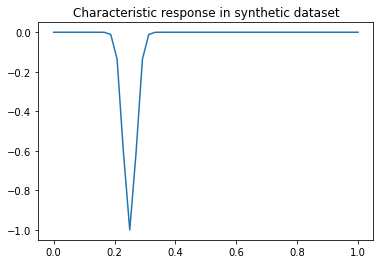

In [79]:
xs, ys = simple_gaussian(params.b, params.a, dataset.sample_rate)
ys = coef_mean[-1] * ys
plt.plot(xs, ys)

plt.title("Characteristic response in synthetic dataset")

### Visualize epoched data

In [80]:
# Epoch data.
epoch_tmin, epoch_tmax = torch.tensor(epoch_window)
epoch_samples = time_to_sample(epoch_tmax - epoch_tmin, dataset.sample_rate)
Y_epoch = torch.zeros((dataset.X_variable.shape[0], epoch_samples, dataset.Y.shape[-1]))
for i, word_onset in enumerate(dataset.word_onsets):
    word_onset_sample = time_to_sample(word_onset, dataset.sample_rate)
    word_offset_sample = word_onset_sample + epoch_samples
    Y_epoch[i, :, :] = dataset.Y[word_onset_sample:word_offset_sample, :]

Text(0.5, 0, 'Epoch time')

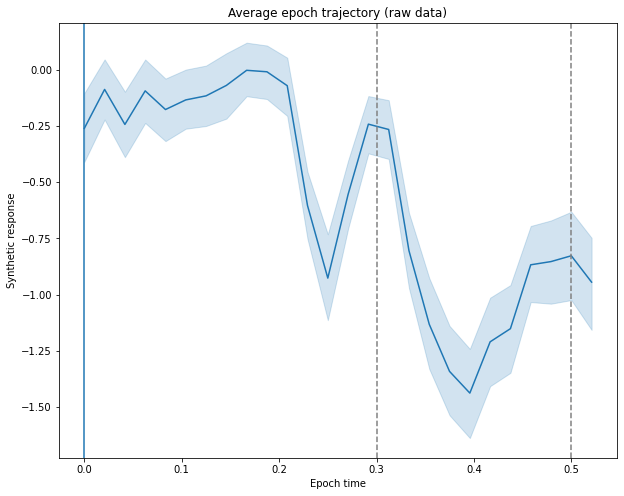

In [81]:
to_plot = pd.DataFrame(Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_variable[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value")
plt.axvline(0.0)
plt.axvline(0.3, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")

plt.title("Average epoch trajectory (raw data)")
plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

Text(0.5, 0, 'Epoch time')

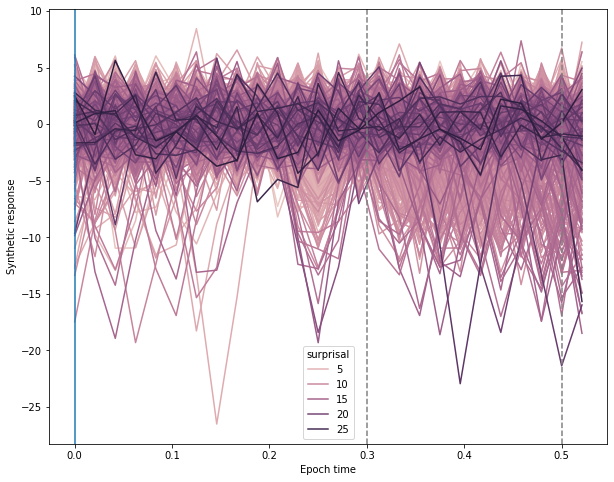

In [82]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)
plt.axvline(0.3, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")

plt.ylabel("Synthetic response")
plt.xlabel("Epoch time")

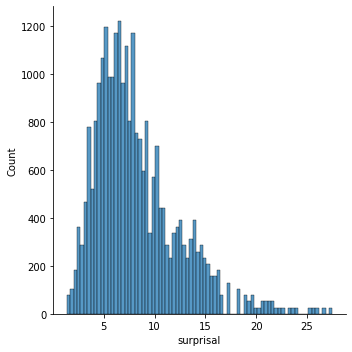

In [83]:
sns.displot(to_plot.surprisal)

## MLE regression

Raw visualization above doesn't produce a very clean EEG response. Let's try estimating a TRF model on the full data and see if we can recover something.

In [84]:
from sklearn.model_selection import ShuffleSplit

n_splits = 10
tmin, tmax = epoch_window
n_features = dataset.X_variable.shape[1] + dataset.X_ts.shape[1]
n_outputs = 1
encoder = TemporalReceptiveField(tmin, tmax, dataset.sample_rate,
                                 n_outputs=n_outputs,
                                 alpha=0)
coefs = torch.zeros((n_splits, n_features, len(encoder.delays_), n_outputs))

X_scatter = scatter_response_model(
    dataset.X_variable,
    dataset.X_ts,
    torch.zeros(dataset.X_variable.shape[0]).long(),
    dataset.phoneme_onsets + dataset.word_onsets.unsqueeze(1),
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])
X_del, _ = TRFDelayer(tmin, tmax, dataset.sample_rate).transform(X_scatter)

idxs = torch.arange(X_scatter.shape[0])

split_size = X_del.shape[0] // n_splits
split_offsets = torch.arange(n_splits) * split_size
for i_split, offset in enumerate(tqdm(split_offsets)):
    idxs_i = idxs[offset:offset + split_size]
    X_i = X_del[idxs_i]
    X_i[:, 1] += torch.randn(X_i[:, 1].shape)
    encoder_i = encoder.fit(X_del[idxs_i], dataset.Y[idxs_i])
    coefs[i_split] = encoder_i.coef_

  0%|          | 0/10 [00:00<?, ?it/s]

In [85]:
coef_df = pd.DataFrame(coefs[:, 0, :, 0])
coef_df.index.name = "fold"
coef_df = coef_df.reset_index().melt(id_vars=["fold"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,fold,epoch_sample,value,epoch_time
0,0,0,0.001688,0.0
1,1,0,-0.082159,0.0
2,2,0,-0.013557,0.0
3,3,0,-0.013874,0.0
4,4,0,-0.002964,0.0
...,...,...,...,...
265,5,26,0.000893,0.541667
266,6,26,-0.190145,0.541667
267,7,26,-0.044439,0.541667
268,8,26,-0.149843,0.541667


Text(0.5, 0, 'Epoch time')

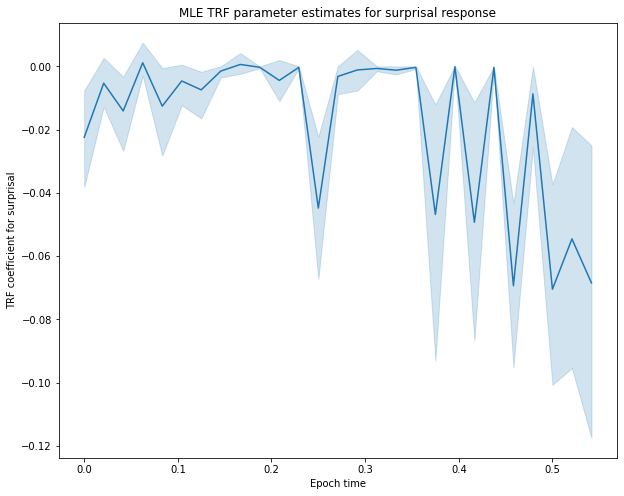

In [86]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value")

plt.title("MLE TRF parameter estimates for surprisal response")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

## EM regression with latent recognition

In [87]:
param_grid = [rr_em.get_parameters() for _ in range(50)]

In [88]:
# HACK
param_grid = em.pipeline.params

In [89]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=50, trf_alpha=1e-2,
                                 epoch_window=(tmin, tmax), solver="sgd",
                                 early_stopping_patience=3)

  0%|          | 0/50 [00:00<?, ?it/s]

In [90]:
coef_df = pd.DataFrame(torch.stack(encoders[1:])[:, 0, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,-0.086146,0.0
1,1,0,-0.056066,0.0
2,2,0,-0.056059,0.0
3,3,0,-0.056059,0.0
4,4,0,-0.056059,0.0
...,...,...,...,...
130,0,26,-0.021189,0.541667
131,1,26,0.004701,0.541667
132,2,26,0.004707,0.541667
133,3,26,0.004707,0.541667


Text(0.5, 0, 'Epoch time')

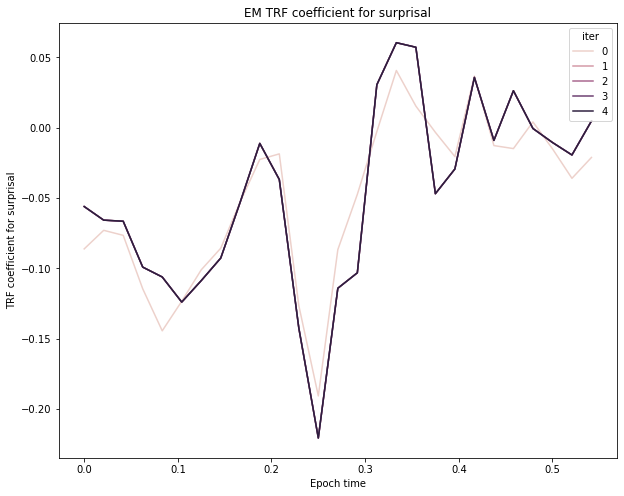

In [91]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")

Text(0.5, 1.0, 'Distribution over weight grid, averaged over iterations')

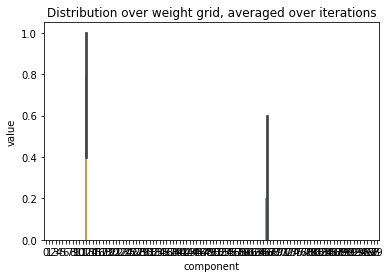

In [92]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

plt.title("Distribution over weight grid, averaged over iterations")

In [93]:
weights.numpy().round(3)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.

In [94]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [95]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0     [0.12575495]
1    [0.016202688]
2    [0.016202688]
3    [0.016202688]
4    [0.016202688]
dtype: object

/home/jgauthie/om2/miniconda/envs/berp/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

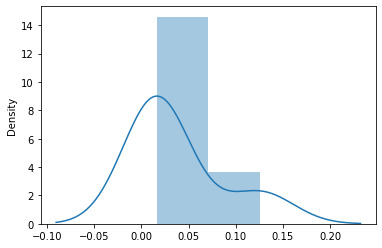

In [96]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [97]:
params.threshold

tensor(0.4394)

## Repro with new EM

In [105]:
from berp.datasets import NestedBerpDataset
from berp.models.trf_em import BerpTRFEM
from berp.solvers import AdamSolver
from optuna.distributions import UniformDistribution

In [99]:
# HACK
dataset.name = f"DKZ_1/{dataset.name}"

In [119]:
em = BerpTRFEM(TemporalReceptiveField(tmin, tmax, dataset.sample_rate, dataset.n_sensors,
                                      optim=AdamSolver(early_stopping=False, n_batches=8),
                                      alpha=1e-2),
               latent_params={"threshold": {0: UniformDistribution(0., 1.)}},
               n_outputs=dataset.n_sensors, n_phonemes=len(dataset.phonemes))

{}


In [120]:
nested = NestedBerpDataset([dataset])

In [123]:
for _ in trange(50):
    em.partial_fit(nested)
    print(em.param_resp_.numpy().round(3))

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:berp.models.trf_em:Priming pipeline for subject 673e7e3b8aed4315ae9d31866656de45
INFO:berp.models.trf_em:Priming pipeline for dataset DKZ_1/673e7e3b8aed4315ae9d31866656de45
INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.060957


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.131442


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.145957


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.149537


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.999 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.151164


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.153194


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.078 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.922 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.154926


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.14 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.86 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.155964


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.184 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.816 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156475


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.207 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.793 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156692


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.217 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.783 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156801


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.223 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.777 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156856


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.225 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.775 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156883


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.227 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.773 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156883


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.227 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.773 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


INFO:berp.models.trf_em:E-step finished
INFO:berp.models.trf_em:M-step finished


torch.Size([41794, 54])


INFO:berp.models.trf_em:Val score: 0.156909


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.228 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.772 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


In [124]:
coef_df = pd.DataFrame(next(iter(em.pipeline.pipelines_.values())).encoder.coef_.unsqueeze(0)[:, 1, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,0.018513,0.0
1,0,1,-0.078100,0.020833
2,0,2,-0.072734,0.041667
3,0,3,-0.092211,0.0625
4,0,4,-0.091544,0.083333
5,0,5,-0.098168,0.104167
6,0,6,-0.041360,0.125
7,0,7,-0.124111,0.145833
8,0,8,-0.080456,0.166667
9,0,9,-0.043580,0.1875


Text(0.5, 0, 'Epoch time')

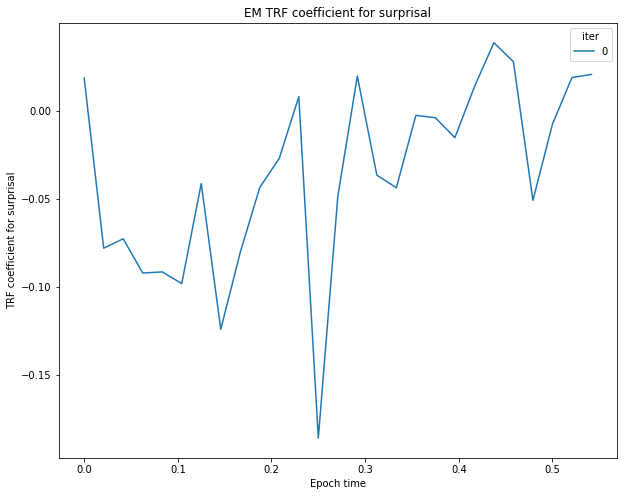

In [125]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

plt.title("EM TRF coefficient for surprisal")
plt.ylabel("TRF coefficient for surprisal")
plt.xlabel("Epoch time")